In [62]:
import numpy as np
import torch
import os
import pickle
from torch.nn.functional import nll_loss, softmax, cross_entropy
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
with open('../steps/domain_lengths.pkl', 'rb') as f:
    domain_lengths = pickle.load(f)

In [4]:
validation_set = np.loadtxt('../data/our_input/validation_domains.csv', dtype='O')
test_set = np.loadtxt('../data/our_input/test_domains.csv', dtype='O')

In [9]:
predicted = np.array([i.split('.')[0] for i in os.listdir('../data/our_input/Y_tensors_2020_04_30_model_93/')])

In [15]:
not_predicted = np.setdiff1d(np.concatenate((validation_set, test_set)), predicted)

In [21]:
for i in not_predicted:
    if domain_lengths[i] > 64:
        print(i)

2ivfA00


---

### Function that takes a domain as an input and returns the losses as a tuple: (alphafold_A), (alphafold_T), (inception)

In [76]:
d = validation_set[0]

# alphafold_A
ala = torch.load(f'../data/our_input/Y_tensors_2020_04_30_model_93/{d}.pred.pt')

# alphafold_T
with open(f'../steps/predicted_outputs/validation/alphafold/{d}_out.pkl', 'rb') as f:
    alt = pickle.load(f)

# inception
with open(f'../steps/predicted_outputs/validation/inception/{d}_out.pkl', 'rb') as f:
    inc = pickle.load(f)

# reality
Y = torch.load(f'../data/our_input/Y_tensors/{d}_Y.pt')

In [82]:
alt['phi'].shape

torch.Size([1, 37, 1, 182])

In [114]:
alt['sec'].shape

torch.Size([1, 9, 1, 182])

In [2]:
def nll_d(d, Y):
    """NLL loss for the distograms"""
    l = torch.empty((len(Y) ** 2))
    for i in range(len(Y)):
        for j in range(len(Y)):
            l[i * len(Y) + j] = - torch.log(d[Y[i, j], i, j])
    return torch.mean(l)

def nll_a(a, Y):
    """NLL loss for auxiliary targets"""
    l = torch.empty((len(Y)))
    for i in range(len(Y)):
        l[i] = - torch.log(a[0, Y[i], 0, i])
    return torch.mean(l)

In [94]:
nll_d(inc['distogram'], Y[0])

tensor(1.5949)

In [121]:
nll_a(inc['psi'], Y[3].to(torch.long))

tensor(2.8379)

In [124]:
cross_entropy(ala[0], Y[0].unsqueeze(dim=0))

tensor(1.4851)

In [116]:
cross_entropy(ala[1], Y[1].unsqueeze(dim=0).to(torch.long) - 1)

tensor(0.4842)

In [113]:
ala[1].shape

torch.Size([1, 8, 182])

In [9]:
def calc_losses(domain):
    
    # reality
    Y = torch.load(f'../data/our_input/Y_tensors/{domain}_Y.pt')
    
    # alphafold_A
    if len(Y[0]) >= 64 and domain != '2ivfA00':
        
        ala = torch.load(f'../data/our_input/Y_tensors_2020_04_30_model_93/{domain}.pred.pt')
        dst_loss = cross_entropy(ala[0], Y[0].unsqueeze(dim=0))
        sec_loss = cross_entropy(ala[1], Y[1].unsqueeze(dim=0).to(torch.long) - 1)
        phi_loss = cross_entropy(ala[2], Y[2].unsqueeze(dim=0))
        psi_loss = cross_entropy(ala[3], Y[3].unsqueeze(dim=0))
        
        alphafold_a = (dst_loss.item(), sec_loss.item(), phi_loss.item(), psi_loss.item())
    else:
        alphafold_a = (None, None, None, None)
    
    # alphafold_T
    with open(f'../steps/predicted_outputs/validation/alphafold/{domain}_out.pkl', 'rb') as f:
        alt = pickle.load(f)
    dst_loss = nll_d(alt['distogram'], Y[0])
    sec_loss = nll_a(alt['sec'], Y[1].to(torch.long))
    phi_loss = nll_a(alt['phi'], Y[2])
    psi_loss = nll_a(alt['psi'], Y[3])
    
    alphafold_t = (dst_loss.item(), sec_loss.item(), phi_loss.item(), psi_loss.item())
    
    # inception
    with open(f'../steps/predicted_outputs/validation/inception/{domain}_out.pkl', 'rb') as f:
        inc = pickle.load(f)
    dst_loss = nll_d(inc['distogram'], Y[0])
    sec_loss = nll_a(inc['sec'], Y[1].to(torch.long))
    phi_loss = nll_a(inc['phi'], Y[2])
    psi_loss = nll_a(inc['psi'], Y[3])
    inception = (dst_loss.item(), sec_loss.item(), phi_loss.item(), psi_loss.item())
    
    # convnet
    with open(f'../steps/predicted_outputs/validation/convnet/{domain}_out.pkl', 'rb') as f:
        inc = pickle.load(f)
    dst_loss = nll_d(inc['distogram'], Y[0])
    sec_loss = nll_a(inc['sec'], Y[1].to(torch.long))
    phi_loss = nll_a(inc['phi'], Y[2])
    psi_loss = nll_a(inc['psi'], Y[3])
    convnet = (dst_loss.item(), sec_loss.item(), phi_loss.item(), psi_loss.item())
    
    return [domain,
            alphafold_a[0], alphafold_t[0], inception[0], convnet[0],  # distance
            alphafold_a[1], alphafold_t[1], inception[1], convnet[1],  # secondary
            alphafold_a[2], alphafold_t[2], inception[2], convnet[2],  # phi
            alphafold_a[3], alphafold_t[3], inception[3], convnet[3]]  # psi
           

In [10]:
val_losses = np.empty((1000, 17), dtype='O')

In [11]:
for i, domain in enumerate(validation_set):
    losses = calc_losses(domain)
    val_losses[i] = losses
    if i % 10 == 0:
        print(f'{i} domains done')

0 domains done
10 domains done
20 domains done
30 domains done
40 domains done
50 domains done
60 domains done
70 domains done
80 domains done
90 domains done
100 domains done
110 domains done
120 domains done
130 domains done
140 domains done
150 domains done
160 domains done
170 domains done
180 domains done
190 domains done
200 domains done
210 domains done
220 domains done
230 domains done
240 domains done
250 domains done
260 domains done
270 domains done
280 domains done
290 domains done
300 domains done
310 domains done
320 domains done
330 domains done
340 domains done
350 domains done
360 domains done
370 domains done
380 domains done
390 domains done
400 domains done
410 domains done
420 domains done
430 domains done
440 domains done
450 domains done
460 domains done
470 domains done
480 domains done
490 domains done
500 domains done
510 domains done
520 domains done
530 domains done
540 domains done
550 domains done
560 domains done
570 domains done
580 domains done
590 doma

In [20]:
lossesdf = pd.DataFrame(val_losses[:, 1:], index=val_losses[:, 0], 
            columns=['DG_Alphafold', 'DG_Alphafold_ZP', 'DG_Inception_ZP', 'DG_ConvNet_ZP', 
                     'SEC_Alphafold', 'SEC_Alphafold_ZP', 'SEC_Inception_ZP', 'SEC_ConvNet_ZP',
                     'PHI_Alphafold', 'PHI_Alphafold_ZP', 'PHI_Inception_ZP', 'PHI_ConvNet_ZP',
                     'PSI_Alphafold', 'PSI_Alphafold_ZP', 'PSI_Inception_ZP', 'PSI_ConvNet_ZP'])

In [28]:
lossesdf.to_csv('../steps/validation_losses.csv')

In [170]:
from scipy.optimize import linprog

In [181]:
c = dist_losses[0]
A = [[1, 1, 1]]
b = [1]

In [185]:
linprog(c, A_eq=A, b_eq=b)

     con: array([-7.29427629e-11])
     fun: 1.485136389897808
 message: 'Optimization terminated successfully.'
     nit: 4
   slack: array([], dtype=float64)
  status: 0
 success: True
       x: array([1.00000000e+00, 6.50242961e-13, 5.19007991e-10])

In [183]:
c

array([1.48513639, 1.72377181, 1.59488797])

In [13]:
dist_losses = val_losses[:, 1:5].astype(np.float)

In [18]:
np.sum(np.isnan(dist_losses[:, 0]))

152

In [21]:
lossesdf

,DG_Alphafold,DG_Alphafold_ZP,DG_Inception_ZP,DG_ConvNet_ZP,SEC_Alphafold,SEC_Alphafold_ZP,SEC_Inception_ZP,SEC_ConvNet_ZP,PHI_Alphafold,PHI_Alphafold_ZP,PHI_Inception_ZP,PHI_ConvNet_ZP,PSI_Alphafold,PSI_Alphafold_ZP,PSI_Inception_ZP,PSI_ConvNet_ZP
3iekA02,1.48514,1.72377,1.59489,1.5513,0.484214,0.683536,0.565295,0.428094,1.68309,1.74244,1.72011,8.00756,1.77807,2.69935,2.83794,2.67595
4oq1A01,2.306,2.32224,2.27693,2.52647,1.1989,1.21708,1.02538,1.05038,2.35737,2.48807,2.30689,7.97131,2.49931,3.0387,2.99161,2.92068
3tdnA00,1.78227,2.2074,1.97132,1.93129,0.645505,0.837766,0.635358,0.525827,1.81447,1.80987,1.68444,7.88039,1.69602,2.72021,2.81761,2.67991
1v7zA00,1.32251,1.50863,1.44384,1.42773,0.636698,0.839082,0.726193,0.564052,1.74068,1.80638,1.73712,7.38779,1.81096,2.74644,2.79688,2.64464
3no4B00,1.33068,1.53215,1.37885,1.3836,0.499478,0.664711,0.583221,0.460836,1.65028,1.72224,1.72295,7.18926,1.80002,2.60824,2.72059,2.51839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2kloA00,1.45464,1.65419,1.47248,1.63096,0.98725,0.83326,0.822329,0.895794,2.34224,2.18563,2.10748,6.2944,2.73393,3.24685,3.23939,3.06583
4cihA00,2.24438,2.09191,2.18942,2.38461,1.25269,0.900358,0.727791,0.707652,2.71187,3.04496,2.71248,5.06925,3.01598,3.06949,3.18804,2.95227
3fuyA00,2.17868,2.22868,2.20807,2.35504,0.971677,0.989348,0.928662,0.926927,2.19901,2.26236,2.17503,7.03435,2.34527,2.90802,2.92262,2.8732
4mbqC00,None,1.94795,1.61286,1.52263,None,0.12998,0.119937,0.240135,None,1.12802,1.00722,7.17221,None,2.08631,2.21271,2.0547


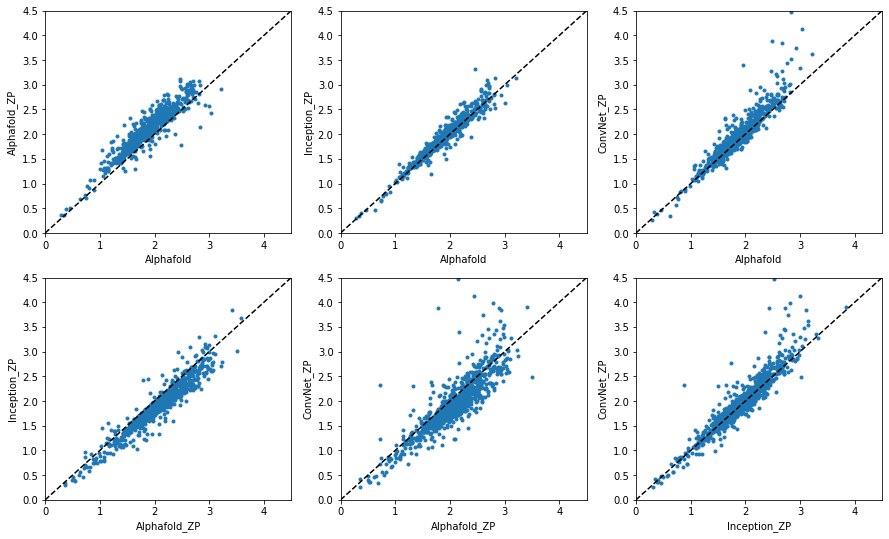

In [31]:
fig, ax = plt.subplots(2, 3, figsize=(15, 9))

models = ['DG_Alphafold', 'DG_Alphafold_ZP', 'DG_Inception_ZP', 'DG_ConvNet_ZP']
ind_i, ind_j = 0, 0

for i in range(3):
    for j in range(i + 1, 4):
        ax[ind_i, ind_j].plot(lossesdf.loc[:, models[i]], lossesdf.loc[:, models[j]], '.')
        ax[ind_i, ind_j].set_xlabel(models[i].split('G_')[1])
        ax[ind_i, ind_j].set_ylabel(models[j].split('G_')[1])
        
        ax[ind_i, ind_j].plot(np.linspace(0, 4.5, 30), np.linspace(0, 4.5, 30),'--k')
        ax[ind_i, ind_j].set_xlim(0, 4.5)
        ax[ind_i, ind_j].set_ylim(0, 4.5)
        ind_j += 1
        if ind_j >= 3:
            ind_j = 0
            ind_i += 1

plt.savefig('../plots/models_validation_distogram_losses.png')

In [3]:
def normal_distr(x, mu, sigma):
    """
    Find probability of a value "x" in a normal distribution with mean
    "mu" and standard deviation "sigma"
    """
    
    return 1/(sigma * torch.sqrt(torch.tensor(2 * np.pi))) * torch.exp((-1/2) * ((x - mu) / sigma) ** 2)

In [6]:
x = torch.linspace(2, 22, 31)
n = torch.tensor([normal_distr(i, 8, 2) for i in x])

dij = 6.5

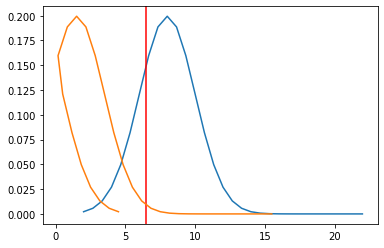

In [11]:
plt.plot(x, n)
plt.axvline(dij, c='r')
plt.plot(torch.abs(x - dij), n)

In [43]:
from Bio.PDB import PDBParser, protein_letters_3to1

CACB = 1.52
CCACB = torch.tensor(np.radians(150))
CAC = 1.52
class cbatom:
    def __init__(self, N, CA, C):
        self.residue = torch.cat((torch.tensor(N.get_coord()).view(1, 3), 
                                 torch.tensor(CA.get_coord()).view(1, 3), 
                                 torch.tensor(C.get_coord()).view(1, 3)))
    
    def cross_product(self, k, v):
        # definition of cross product
        cp = torch.tensor([
            k[1] * v[2] - k[2] * v[1],
            k[2] * v[0] - k[0] * v[2],
            k[0] * v[1] - k[1] * v[0]
        ])
        return cp
    
    def rodrigues(self, v, k, angle):
        """
        Rotate vector "v" by a angle around basis vector "k"
        see: https://en.wikipedia.org/wiki/Rodrigues%27_rotation_formula
        
        My Implementation - commented is official rodrigues formula
        
        Input:
            v    : a 1D torch tensor
            k    : a 1D unit torch tensor
            angle: an angle in radians as a torch tensor
        
        Output:
            rotated vector: 1D torch tensor
        """

        n = self.cross_product(k, v)
        n = n / torch.sqrt(torch.sum(n ** 2))

        m = self.cross_product(n, k)
        m = m / torch.sqrt(torch.sum(m ** 2))

        kv = torch.sum(k * v)
        mv = torch.sum(m * v)

        v_s = torch.sqrt(torch.sum(v ** 2))

        k_axis = k * kv
        n_axis = n * torch.sin(angle) * mv
        m_axis = m * torch.cos(angle) * mv

        vrot = k_axis + n_axis + m_axis
        
        return vrot
    
    def get_coord(self):
        """
        Calculate coordinates of C-beta atom. 
        
        Input:
            residue: a 2D torch tensor of coordinates in the order N, CA, C
        
        Output
            coordinates of the C-beta atom: 1D torch tensor
        """

        v1 = self.residue[0] - self.residue[1]  # vector CA-N
        v2 = self.residue[2] - self.residue[1]  # vector CA-C

        v1_scaled = CAC * (v1 / torch.sqrt(torch.sum(v1 ** 2)))

        n = v2 - v1_scaled
        n = n / torch.sqrt(torch.sum(n ** 2))

        k = self.cross_product(v2, v1)
        k = k / torch.sqrt(torch.sum(k ** 2))

        return self.rodrigues(k, n, CCACB) * CACB + self.residue[1]

import numpy as np

def str_to_int(s):
    nums = '0123456789'
    for i in s:
        if i in nums:
            pass
        else:
            return None
    return int(s)

domains = {}
with open('../data/our_input/cath-domain-seqs-S35.fa') as f:
    while True:
        info = f.readline()
        if info == '':
            break
            
            # extract domain id and positions
        domain, pos = info.strip().split('|')[2].split('/')
        pos = pos.split('_') # in case the domain is not continuous
        
        if len(pos) == 1:  # we only allow continous domains 
            start, end = pos[0].strip('-').split('-')
            start, end = str_to_int(start), str_to_int(end) # check if there is a character in position
            if start is None or end is None:
                f.readline()
            else:
                domains[domain] = [
                    start, end,
                    f.readline().strip()]
        else:
            f.readline()


def get_coords(domain):
    
    domain_start, domain_end = domains[domain][0], domains[domain][1]
    domain_id = domain[:4]
    chain_id = domain[4]
    
    
    structure = PDBParser().get_structure('', f'../data/pdbfiles/{domain_id}.pdb')
    
    if chain_id == '0':
        # get all chain_IDs
        chain_IDs = np.array([ch.get_full_id()[2] for ch in structure.get_chains()])
        if '0' in chain_IDs:
            pass
        else:
            chain_id = ' '
    
    # Extract Chain from the Domain
    chain = structure[0][chain_id]
    
    coords_list = []
    domain_size = domain_end - domain_start + 1
    
    known_aminoacids = np.array(list(protein_letters_3to1.keys()))
    
    for i, residue in enumerate(chain.get_residues()):
        
        residue_name = residue.get_resname()
        
        if residue_name not in known_aminoacids: 
            break

        residue_oneletter = protein_letters_3to1[residue_name]
        residue_number = residue.child_list[0].get_full_id()[3][1]
        
        if residue_oneletter == 'G': # if Glycin -> C-alpha. Otherwise C-beta
            try:
                CA = residue['CA']
                
                for atom in [CA]:
                    x, y, z = atom.get_coord()
                    coords_list.append([residue_number,  
                                        residue_name,
                                        residue_oneletter,
                                        atom.fullname.strip(),
                                        x, y, z])
            except:
                print('CA Atom not found')
                return
        else:
            
            try:
                CB = residue['CB']
            except:
                try:
                    C = residue['C']
                    N = residue['N']
                    CA = residue['CA']
                except:
                    print('One of backbone atoms not found')
                    return
                
                CB = cbatom(N, CA, C)
                
            for atom in [CB]:
                x, y, z = atom.get_coord()
                coords_list.append([residue_number,  
                                    residue_name,
                                    residue_oneletter,
                                    'CB',
                                    x, y, z])                  
            #except:
            #    print('Atom not found')
            #    return

        
        if residue_number == domain_end: # because we need to include also that residue
            break
            
    coords_list = np.array(coords_list, dtype='O')
    
    start = np.where(coords_list[:, 0] == domain_start)[0][0]
    end = np.where(coords_list[:, 0] == domain_end)[0][0]
    
    coords_list = coords_list[start:(end + 1)]
    
    if coords_list[:, 0][-1] - coords_list[:, 0][0] + 1 != len(coords_list):
        print('Fuckit', len(coords_list))
        return
    return coords_list
 

In [91]:
validation_coords = {}
iamidiot = []

In [92]:
for i in range(1000):
    domain = validation_set[i]
    c = get_coords(domain)
    if c is None:
        iamidiot.append(domain)
        
    validation_coords[validation_set[i]] = c

/home/tomasla/miniconda3/envs/dssp/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 14681.
  warnings.warn(
/home/tomasla/miniconda3/envs/dssp/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 14836.
  warnings.warn(
/home/tomasla/miniconda3/envs/dssp/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 15006.
  warnings.warn(
/home/tomasla/miniconda3/envs/dssp/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 15123.
  warnings.warn(
/home/tomasla/miniconda3/envs/dssp/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 15215.
  warnings.warn(
/home/tomasla/miniconda3/envs/dssp/lib/python3.8/site-packages/Bio/PDB/Stru

In [94]:
len(validation_coords)

1000

In [ ]:
with open('../steps/validation_coords.pkl', 'wb') as f:
    pickle.dump(validation_coords, f)

In [115]:
a = validation_coords[validation_set[0]]

In [124]:
def dist_map(coords):
    xyz = torch.from_numpy(coords[:, 4:].astype(np.float))
    L = len(coords)
    distmap = torch.zeros((L, L))
    for i in range(L - 1):
        for j in range(i, L):
            distmap[i, j] = torch.sqrt(torch.sum((xyz[i] - xyz[j]) ** 2))
    return distmap + distmap.t()

In [125]:
validation_distmaps = {}

In [126]:
for d in validation_coords:
    validation_distmaps[d] = dist_map(validation_coords[d])

In [127]:
len(validation_distmaps)

1000

In [128]:
with open('../steps/validation_distmaps.pkl', 'wb') as f:
    pickle.dump(validation_distmaps, f)

# D-lddt

$$DlDDT = \frac{100}{4L} \sum_{t \in \{0.5, 1, 2, 4\}} \frac{\sum_{i=0}^L \sum_{\substack{j=0\\j \neq i\\D_{ij} < 15}}^L \mathcal{P}(|D_{ij} - d{ij}| < t)|\mathcal{S}, MSA)}{\sum_{i=0}^L \sum_{\substack{j=0\\j \neq i\\D_{ij} < 15}}^L 1}$$

In [44]:
with open('../steps/validation_distmaps.pkl', 'rb') as f:
    validation_distmaps = pickle.load(f)

In [50]:
def dlddt(D, d):
    """
    Calculate Distogram local difference distance test score
    
    D: real distance map
    d: predicted distogram shape=(32, L, L) - SOFTMAX
    """
    L = len(D)
    x = torch.linspace(2, 22, 31)
    
    lddt = []
    for t in [0.5, 1, 2, 4]:
        t_lddt = []
        for i in range(L):
            for j in range(L):
                if i != j and D[i, j] <= 15:
                    # sum up the probabilities around the real distance value
                    abs_D_minus_d = torch.abs(x - D[i, j])
                    probs = d[1:, :, :][torch.where(abs_D_minus_d <= t)[0], i, j]
                    t_lddt.append(torch.sum(probs).item())
        
        lddt.append(np.mean(t_lddt))
    return 100 * np.sum(lddt) / 4

In [51]:
def models_dlddt(domain, D):
    """
    Calculate distogram lDDT for the 4 models
    
    D is the real distance map
    """

    L = len(D)
    # alphafold_A
    if L >= 64 and domain != '2ivfA00':
        # alphafold_A
        ala = torch.load(f'../data/our_input/Y_tensors_2020_04_30_model_93/{domain}.pred.pt')
        d = softmax(ala[0][0], dim=0)
        alphafold_a = dlddt(D, d)
        
    else:
        alphafold_a = None
    
    # alphafold_T
    with open(f'../steps/predicted_outputs/validation/alphafold/{domain}_out.pkl', 'rb') as f:
        alt = pickle.load(f)
    
    d = alt['distogram']
    alphafold_t = dlddt(D, d)
    
    # inception
    with open(f'../steps/predicted_outputs/validation/inception/{domain}_out.pkl', 'rb') as f:
        inc = pickle.load(f)
    d = inc['distogram']
    inception = dlddt(D, d)
    
    # convnet
    with open(f'../steps/predicted_outputs/validation/convnet/{domain}_out.pkl', 'rb') as f:
        con = pickle.load(f)
    
    d = con['distogram']
    convnet = dlddt(D, d)
    
    return [domain, alphafold_a, alphafold_t, inception, convnet]

In [53]:
YD = validation_distmaps[validation_set[0]]
models_dlddt(validation_set[0], YD)

['3iekA02',
 53.642323048693484,
 42.541364773737975,
 49.95754179025637,
 55.286768229428716]

In [54]:
lddt_scores = np.empty((1000, 5), dtype='O')

In [55]:
for i, domain in enumerate(validation_set):
    D = validation_distmaps[domain]
    lddt_scores[i] = models_dlddt(domain, D)
    
    if i % 10 == 0:
        print(f'{i} domains done')

0 domains done
10 domains done
20 domains done
30 domains done
40 domains done
50 domains done
60 domains done
70 domains done
80 domains done
90 domains done
100 domains done
110 domains done
120 domains done
130 domains done
140 domains done
150 domains done
160 domains done
170 domains done
180 domains done
190 domains done
200 domains done
210 domains done
220 domains done
230 domains done
240 domains done
250 domains done
260 domains done
270 domains done
280 domains done
290 domains done
300 domains done
310 domains done
320 domains done
330 domains done
340 domains done
350 domains done
360 domains done
370 domains done
380 domains done
390 domains done
400 domains done
410 domains done
420 domains done
430 domains done
440 domains done
450 domains done
460 domains done
470 domains done
480 domains done
490 domains done
500 domains done
510 domains done
520 domains done
530 domains done
540 domains done
550 domains done
560 domains done
570 domains done
580 domains done
590 doma

In [56]:
lddt_df = pd.DataFrame(lddt_scores[:, 1:].astype(np.float), index = lddt_scores[:, 0], columns=['Alphafold', 'Alphafold_ZP', 'Inception_ZP', 'ConvNet_ZP'])

In [57]:
lddt_df.to_csv('../steps/models_lddt.csv')

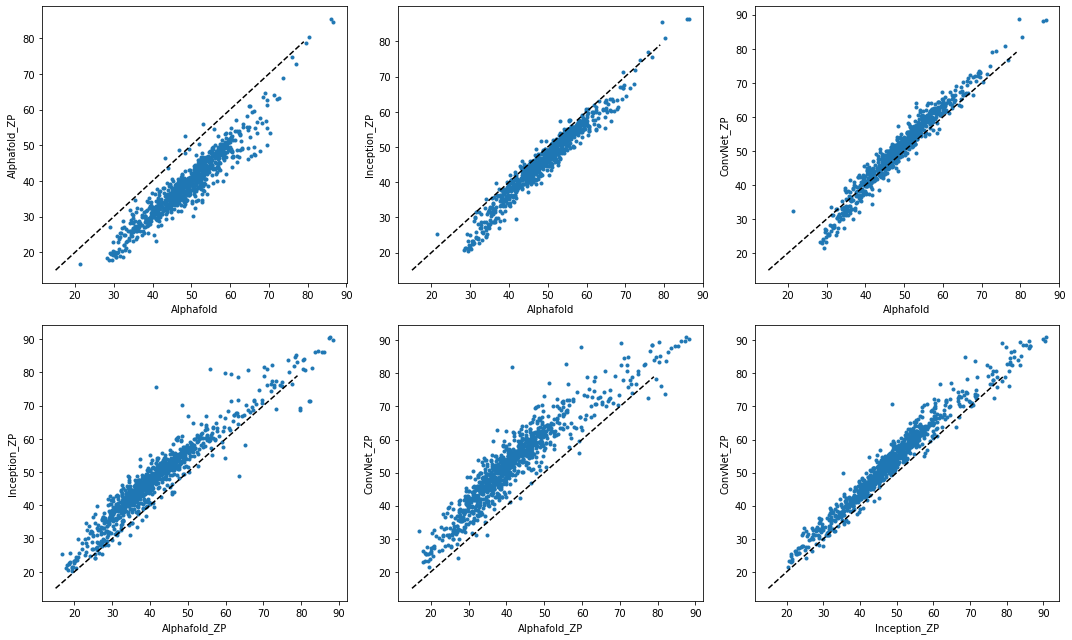

In [59]:
models = ['Alphafold', 'Alphafold_ZP', 'Inception_ZP', 'ConvNet_ZP']

fig, ax = plt.subplots(2, 3, figsize=(15, 9))

ind_i = 0
ind_j = 0

for i in range(3):
    for j in range(i+1, 4):
        ax[ind_i, ind_j].plot(lddt_df.loc[:, models[i]], lddt_df.loc[:, models[j]], '.')
        ax[ind_i, ind_j].set_xlabel(models[i])
        ax[ind_i, ind_j].set_ylabel(models[j])
        
        ax[ind_i, ind_j].plot(np.arange(15, 80), np.arange(15, 80), '--k')
        ind_j += 1
        if ind_j >= 3:
            ind_j = 0
            ind_i += 1
plt.tight_layout()

plt.savefig('../plots/models_lddt.png')

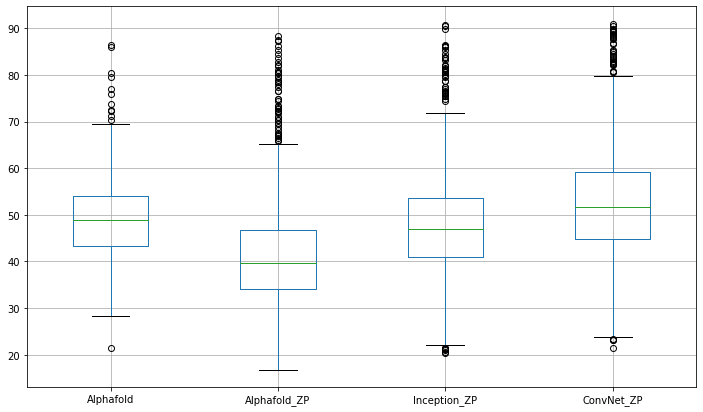

In [71]:
fig = plt.figure(figsize = (12, 7))
lddt_df.boxplot()

plt.savefig('../plots/models_lddt_boxplots.png')